# Machine Learning Final Project with Cora Dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from scapy.all import *
# from pcapng import FileScanner
import networkx as nx
from mpl_toolkits.mplot3d import axes3d
import os 

import torch
import torch.optim as optim
import torch.nn as nn

import seaborn as sns
from torch.nn import Sequential
import random
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from torch.utils.data import Dataset ,DataLoader
from torchvision import transforms


from torch_geometric.nn import GCNConv
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from pycaret.datasets import get_data
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.utils import to_networkx

from torch_geometric.utils import to_networkx

import sklearn
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import metrics
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"set_seed_{seed}")
set_seed(42)

from tqdm.auto import trange,tqdm
from torch_geometric.datasets import Planetoid
from modules.metrics import *
%matplotlib inline
print("PyTorch has version {}".format(torch.__version__))

# from torch_geometric.datasets import CoraFull

set_seed_42
PyTorch has version 1.13.0


# EDA 

In [2]:
edgelist = pd.read_csv("./Cora/cora.cites", sep='\t', header=None, names=["target", "source"])
# edgelist["label"] = "cites"
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
content  = pd.read_csv("./Cora/cora.content",sep='\t',header=None,names =column_names)

In [300]:
content  = pd.read_csv("./Cora/cora.content",sep='\t',header=None,names =column_names)
content

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
117328,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [3]:
#label이름이 들어있음, 
label_list = list(pd.get_dummies(content['subject']).columns)
label_list

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [302]:
content["subject"].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64

In [4]:
Ordinary_encode = {i:idx for idx,i in enumerate(label_list)}
content["subject"] = content["subject"].map(Ordinary_encode)
content['subject']

31336      2
1061127    5
1106406    4
13195      4
37879      3
          ..
1128975    1
1128977    1
1128978    1
117328     0
24043      2
Name: subject, Length: 2708, dtype: int64

Ordinary Encoding을 진행 

In [5]:
edgelist #edge는 인용 여부 target이 source의 논문을 cite 

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [299]:
content

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
117328,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### edgelist: 참조된 논문 -> 참조한 논문   
### content : 논문의 id , 각 논문의 feature 정보(1433개의 단어중 논문에 단어가 존재하면 1 ) 논문의 장르(classification label)

---------------


## Show correlation 

In [6]:
corr = content.corr()

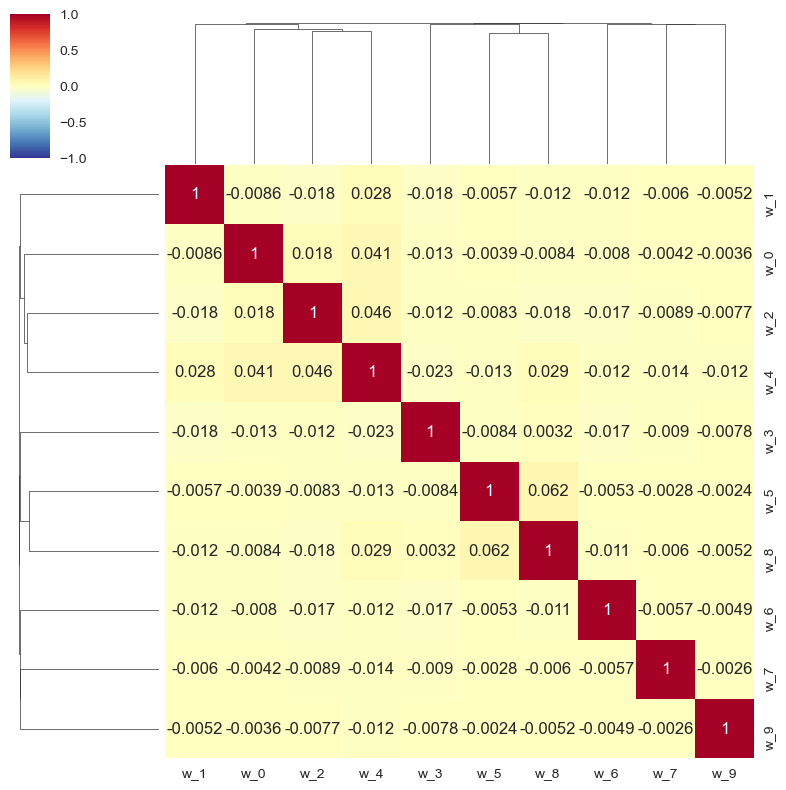

In [7]:

sns.clustermap(corr.iloc[:10,:10],annot =True,
              cmap = "RdYlBu_r",
              vmin = -1,vmax =1,figsize=(8,8))
plt.savefig("./jpeg/corr.jpeg",dpi=200)
plt.show()

## histogram

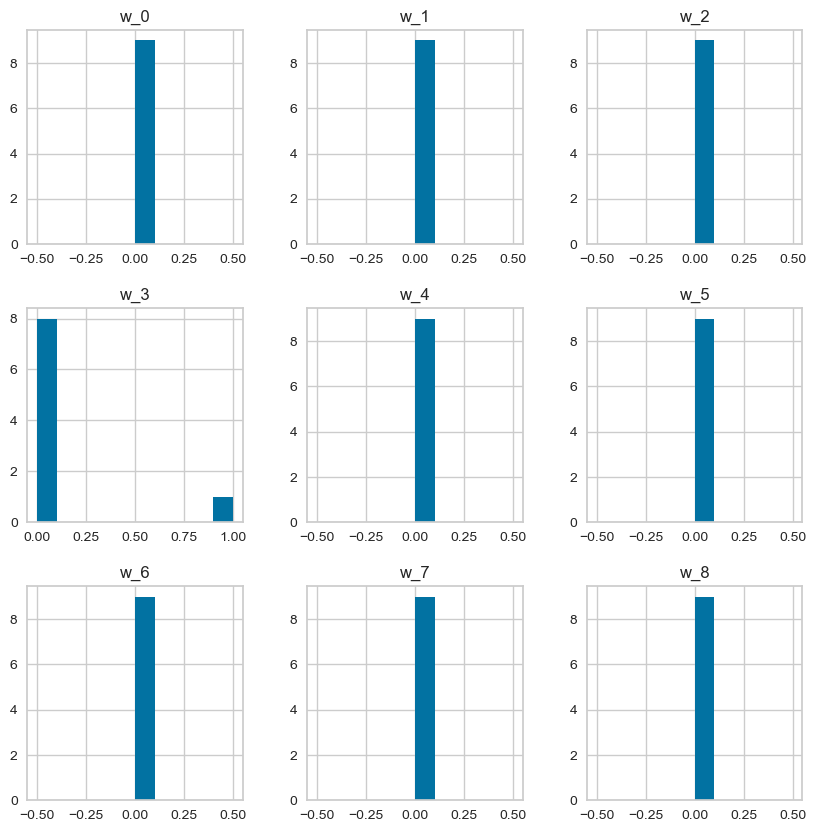

In [8]:
#간단하게 9개에 대한 hist gram을 출력해볼까요 
content.iloc[0:9,0:9].hist(figsize=(10,10))
plt.savefig("./jpeg/hist.jpeg",dpi=200)
plt.show()

# histogram과 correlation을 보면 파악 할 수 있다시피 각각의 feature들 끼리는 크게 상관도가 없는 것 처럼 보인다. 
-----
## feature는 냅두고 train , test set으로 dataset을 분리

In [9]:
train_,test = train_test_split(content,test_size=0.2,random_state=42,stratify=content["subject"])
train, valid = train_test_split(train_,test_size=0.2 ,random_state=42,stratify=train_["subject"])

In [10]:
train_x = train.drop(columns = 'subject',axis=1)
train_y = train["subject"]
valid_x = valid.drop(columns = 'subject',axis=1)
valid_y = valid["subject"]
test_x = test.drop(columns = 'subject',axis=1)
test_y = test["subject"]

train_x  = np.array(train_x,dtype = np.float32)
train_y  = np.array(train_y,dtype = np.float32)
valid_x  = np.array(valid_x,dtype = np.float32)
valid_y  = np.array(valid_y,dtype = np.float32)
test_x   = np.array(test_x, dtype = np.float32)
test_y   = np.array(test_y, dtype = np.float32)


## high-dimensional data를 visualization을 하기 위한 2가지 방법이 존재한다.  
# 1.PCA  
# 2.Tsne  

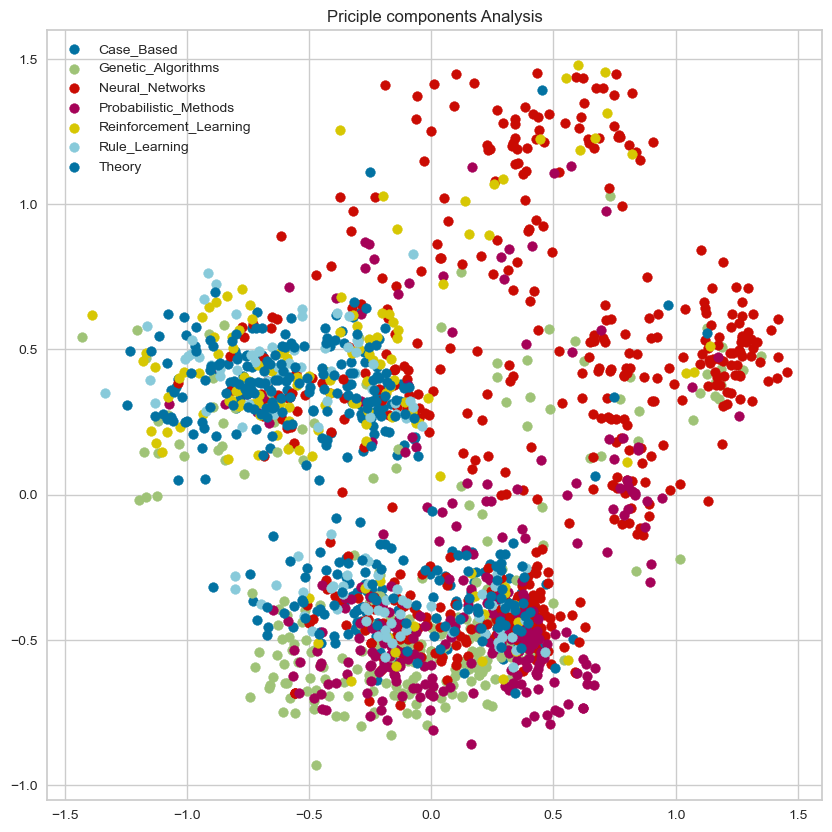

In [11]:
visualize_2d(train_x,train_y,label_list,save = True,mode ="pca")

In [12]:
def tsne(data,label,label_list,save=True):
    tsne = TSNE(n_components=2) # 2 차원으로 축소 
    components = tsne.fit_transform(data) #data에 대해서 transform 진행 

    plt.figure(figsize=(10,10))

    x = [[],[],[],[],[],[],[]]
    y = [[],[],[],[],[],[],[]]
    for idx,i in enumerate(label):
        x[int(i)].append(components[idx][0])
        y[int(i)].append(components[idx][1])

    for i in range(7):
        plt.scatter(x[i],y[i],label = label_list[i])
    plt.title(f"Priciple components Analysis")
    plt.legend()
    plt.show()

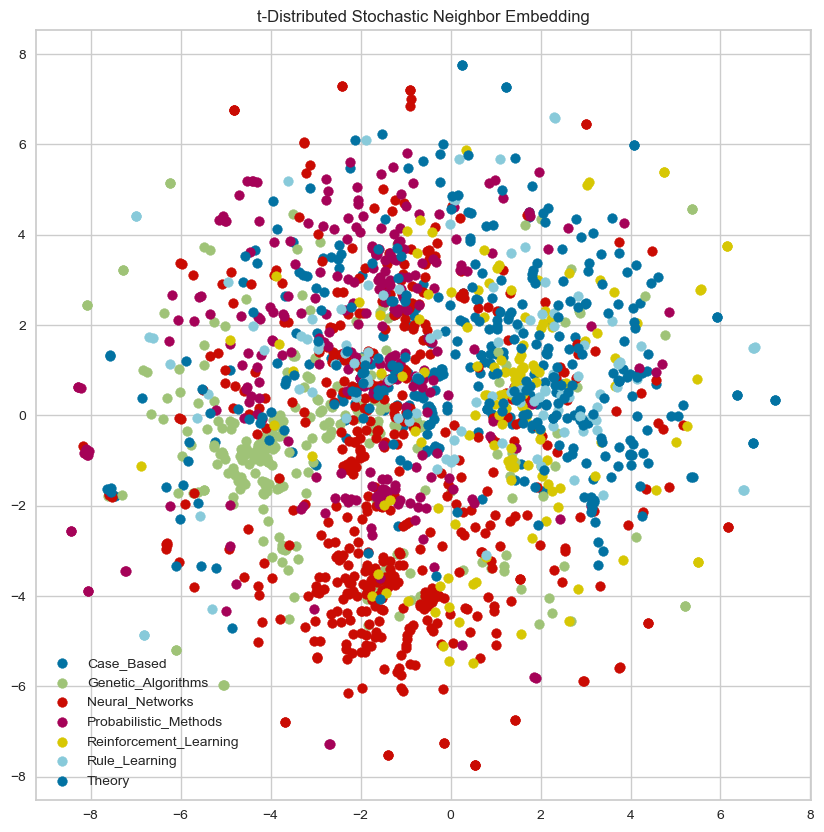

In [13]:
visualize_2d(train_x,train_y,label_list)

<Figure size 1500x1500 with 0 Axes>

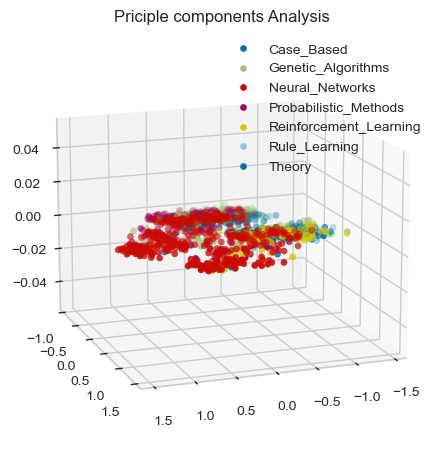

In [14]:
visualize_3d(train_x,train_y,label_list,save = True,mode ='pca')

<Figure size 1500x1500 with 0 Axes>

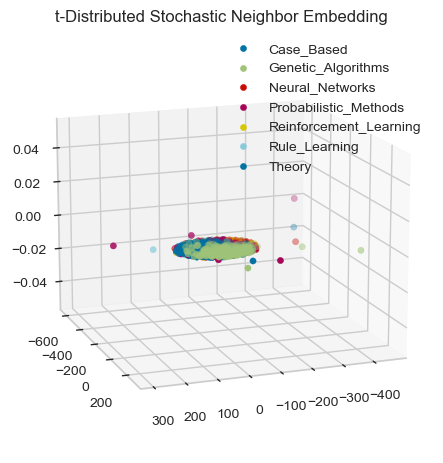

In [15]:
visualize_3d(train_x,train_y,label_list,save = True)

In [16]:
from pycaret.classification import *
setup_clf = setup(data = train_,target='subject',train_size=0.7,
                  # numeric_features = ["Duration","Src Pt","Dst Pt",],
                  # Remove Perfect Collinearity=True
                  use_gpu = True,
                  remove_perfect_collinearity=True,
                 session_id=1212)

,Description,Value
0,session_id,1212
1,Target,subject
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(2166, 1434)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,1433
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='subject',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [17]:
#5가지 좋은 모델을 select
best_model = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7394,0.9413,0.6983,0.7453,0.7359,0.6796,0.6814,1.4510
catboost,CatBoost Classifier,0.7361,0.9468,0.6897,0.7463,0.7326,0.6740,0.6776,47.9980
et,Extra Trees Classifier,0.7354,0.9373,0.6875,0.7474,0.7297,0.6734,0.6763,0.4200
rf,Random Forest Classifier,0.7302,0.9363,0.6751,0.7448,0.7236,0.6652,0.6693,0.4390
gbc,Gradient Boosting Classifier,0.7209,0.9329,0.6561,0.7397,0.7129,0.6504,0.6593,14.4340
lightgbm,Light Gradient Boosting Machine,0.7196,0.9327,0.6740,0.7257,0.7157,0.6551,0.6576,2.2540
ridge,Ridge Classifier,0.6643,0.0000,0.6268,0.6725,0.6613,0.5886,0.5906,0.0660
dt,Decision Tree Classifier,0.6016,0.7560,0.5774,0.6067,0.5995,0.5138,0.5151,0.1710
svm,SVM - Linear Kernel,0.5201,0.0000,0.4994,0.7250,0.5035,0.4269,0.4782,0.1640
ada,Ada Boost Classifier,0.5105,0.7457,0.4839,0.5501,0.5097,0.3969,0.4024,0.6370


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), <catboost.core.CatBoostClassifier object at 0x0000021785FFC100>, ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1212, verbose=0,


# 가장 좋은 모델은 catboost, rf, gbr ,lightbgm, br이 top 5인 것으로 보임

In [18]:
best_model # 가장 좋은 모델이 저장되어 있음 

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=1212, verbose=0,
                      warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=No

In [19]:
#first test
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7368,0.9378,0.6899,0.7362,0.7336,0.6773,0.6781
1,0.7368,0.9504,0.6898,0.7444,0.7338,0.6757,0.6787
2,0.7961,0.9561,0.7616,0.8102,0.7908,0.7491,0.7515
3,0.6974,0.9179,0.6608,0.7095,0.6980,0.6272,0.6298
4,0.7368,0.9434,0.6828,0.7531,0.7308,0.6754,0.6772
5,0.7368,0.9470,0.6877,0.7451,0.7345,0.6754,0.6777
6,0.7682,0.9537,0.7000,0.7584,0.7585,0.7156,0.7171
7,0.6954,0.9269,0.6559,0.7008,0.6899,0.6234,0.6260
8,0.7417,0.9446,0.7192,0.7422,0.7401,0.6835,0.6840


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 3
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [20]:
tune_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7434,0.9391,0.6997,0.7462,0.7420,0.6877,0.6886
1,0.7368,0.9487,0.6997,0.7535,0.7406,0.6802,0.6818
2,0.7763,0.9553,0.7668,0.7828,0.7761,0.7276,0.7286
3,0.6974,0.9203,0.6846,0.7110,0.6996,0.6318,0.6333
4,0.7237,0.9460,0.7094,0.7365,0.7219,0.6657,0.6679
5,0.7632,0.9449,0.7197,0.7734,0.7632,0.7117,0.7129
6,0.7483,0.9509,0.7015,0.7477,0.7450,0.6955,0.6967
7,0.7285,0.9291,0.7008,0.7332,0.7269,0.6679,0.6689
8,0.7483,0.9438,0.7453,0.7493,0.7472,0.6944,0.6948


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 4
INFO:logs:LogisticRegression(C=0.846, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [21]:
evaluate_model(tune_lr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LogisticRegression(C=0.846, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [22]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.9346,0.6941,0.7545,0.7441,0.6906,0.6936
1,0.6974,0.9398,0.6412,0.7096,0.6913,0.6234,0.6290
2,0.7697,0.9441,0.7250,0.7819,0.7678,0.7158,0.7183
3,0.7105,0.9365,0.6532,0.7471,0.7064,0.6387,0.6457
4,0.7697,0.9408,0.7320,0.7770,0.7642,0.7158,0.7180
5,0.7237,0.9453,0.6554,0.7312,0.7159,0.6565,0.6603
6,0.7550,0.9431,0.6802,0.7636,0.7406,0.6949,0.7004
7,0.6821,0.9109,0.6206,0.7010,0.6737,0.6042,0.6090
8,0.7285,0.9488,0.6627,0.7525,0.7175,0.6656,0.6687


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 5
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1212, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [23]:
tune_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7039,0.9110,0.7076,0.7200,0.7059,0.6440,0.6464
1,0.7829,0.9451,0.7724,0.7941,0.7855,0.7371,0.7383
2,0.7303,0.9219,0.7274,0.7424,0.7330,0.6745,0.6756
3,0.7237,0.9119,0.7442,0.7422,0.7272,0.6686,0.6710
4,0.6645,0.9230,0.6805,0.7074,0.6663,0.6018,0.6093
5,0.7105,0.9243,0.6790,0.7228,0.7131,0.6513,0.6528
6,0.6821,0.9218,0.6705,0.7190,0.6896,0.6190,0.6230
7,0.6887,0.9024,0.6915,0.7079,0.6913,0.6239,0.6259
8,0.7483,0.9351,0.7394,0.7636,0.7470,0.6981,0.7020


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 6
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=-1, oob_score=False, random_state=1212, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [49]:
tune_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=220, n_jobs=-1, oob_score=False,
                      random_state=777, verbose=0, warm_start=False)

In [24]:
evaluate_model(tune_rf)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=-1, oob_score=False, random_state=1212, verbose=0,
                       warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [25]:
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6382,0.0000,0.6208,0.7802,0.6192,0.5631,0.5792
1,0.6513,0.0000,0.5970,0.8219,0.6550,0.5824,0.6069
2,0.4868,0.0000,0.5582,0.7657,0.4661,0.4080,0.4504
3,0.5921,0.0000,0.5407,0.7485,0.5470,0.4981,0.5206
4,0.6842,0.0000,0.6317,0.7477,0.6757,0.6130,0.6246
5,0.6382,0.0000,0.6344,0.7909,0.6363,0.5723,0.5948
6,0.2715,0.0000,0.2552,0.7109,0.2533,0.1479,0.2726
7,0.5695,0.0000,0.5152,0.6825,0.5256,0.4595,0.4835
8,0.3444,0.0000,0.3270,0.6341,0.3433,0.2268,0.3468


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 7
INFO:logs:SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [26]:
tune_svm = tune_model(svm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7171,0.0000,0.6547,0.7416,0.7128,0.6487,0.6536
1,0.7039,0.0000,0.6464,0.7140,0.6988,0.6319,0.6369
2,0.7039,0.0000,0.6242,0.7564,0.6969,0.6278,0.6380
3,0.6447,0.0000,0.5648,0.6932,0.6331,0.5529,0.5650
4,0.6908,0.0000,0.6284,0.7248,0.6867,0.6173,0.6214
5,0.6842,0.0000,0.5976,0.6862,0.6706,0.6044,0.6112
6,0.6954,0.0000,0.6428,0.7038,0.6901,0.6265,0.6292
7,0.6159,0.0000,0.5507,0.6546,0.6077,0.5203,0.5287
8,0.6887,0.0000,0.6167,0.7008,0.6786,0.6113,0.6168


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 8
INFO:logs:SGDClassifier(alpha=0.005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
              l1_ratio=0.5500000001, learning_rate='invscaling', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [27]:
tune_svm

SGDClassifier(alpha=0.005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
              l1_ratio=0.5500000001, learning_rate='invscaling', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
evaluate_model(tune_svm)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=SGDClassifier(alpha=0.005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
              l1_ratio=0.5500000001, learning_rate='invscaling', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
tune_svm

SGDClassifier(alpha=0.005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
              l1_ratio=0.5500000001, learning_rate='invscaling', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5592,0.7326,0.5235,0.5591,0.5574,0.4631,0.4634
1,0.6316,0.7722,0.6131,0.6488,0.6329,0.5498,0.5510
2,0.5921,0.7506,0.5985,0.5947,0.5923,0.5065,0.5069
3,0.6250,0.7701,0.5945,0.6300,0.6230,0.5407,0.5424
4,0.6250,0.7705,0.5954,0.6337,0.6223,0.5417,0.5436
5,0.6184,0.7665,0.5738,0.6251,0.6147,0.5320,0.5337
6,0.5695,0.7339,0.5227,0.5774,0.5678,0.4713,0.4733
7,0.5894,0.7446,0.5486,0.5921,0.5854,0.4940,0.4959
8,0.6026,0.7605,0.5848,0.6037,0.5982,0.5195,0.5209


INFO:logs:create_model_container: 24
INFO:logs:master_model_container: 24
INFO:logs:display_container: 9
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1212, splitter='best')
INFO:logs:create_model() succesfully completed......................................


In [30]:
tune_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5461,0.7866,0.4536,0.6900,0.5197,0.4193,0.4472
1,0.5855,0.8561,0.4953,0.7183,0.5873,0.4689,0.4960
2,0.5592,0.8456,0.4688,0.6650,0.5506,0.4408,0.4610
3,0.4868,0.7908,0.4102,0.6490,0.4790,0.3482,0.3717
4,0.5263,0.8041,0.4475,0.5971,0.5097,0.3975,0.4153
5,0.5789,0.8505,0.4827,0.6817,0.5661,0.4616,0.4851
6,0.5960,0.8518,0.5162,0.7464,0.5906,0.4830,0.5134
7,0.5563,0.8046,0.4697,0.7296,0.5473,0.4282,0.4590
8,0.5232,0.8081,0.4378,0.6357,0.5166,0.3883,0.4109


INFO:logs:create_model_container: 25
INFO:logs:master_model_container: 25
INFO:logs:display_container: 10
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.02, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1212, splitter='best')
INFO:logs:tune_model() succesfully completed......................................


In [31]:
evaluate_model(tune_dt)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.02, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1212, splitter='best'), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [84]:
# xg = create_model("xgboost")#xgboost는 gpu가 안됨 
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.9317,0.7032,0.7623,0.7438,0.6896,0.6945
1,0.7171,0.9461,0.6563,0.7424,0.7113,0.6464,0.6571
2,0.7829,0.9410,0.7386,0.7901,0.7801,0.7313,0.7345
3,0.7171,0.9329,0.6633,0.7379,0.7114,0.6456,0.6565
4,0.7500,0.9450,0.6811,0.7659,0.7449,0.6874,0.6942
5,0.7171,0.9224,0.6410,0.7381,0.7071,0.6455,0.6546
6,0.7152,0.9325,0.6388,0.7121,0.7019,0.6445,0.6514
7,0.6556,0.9248,0.5667,0.6960,0.6426,0.5609,0.5815
8,0.7285,0.9409,0.6561,0.7564,0.7172,0.6611,0.6671


INFO:logs:create_model_container: 26
INFO:logs:master_model_container: 26
INFO:logs:display_container: 11
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1212, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [86]:
tune_gbc = tune_model(gbc)
evaluate_model(tune_gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7237,0.9476,0.6868,0.7226,0.7207,0.6627,0.6635
1,0.7566,0.9529,0.6987,0.7598,0.7534,0.7001,0.7024
2,0.7566,0.9394,0.7223,0.7587,0.7539,0.7009,0.7023
3,0.6711,0.9122,0.6269,0.6818,0.6682,0.5924,0.5965
4,0.6842,0.9403,0.6123,0.6708,0.6743,0.6117,0.6128
5,0.7105,0.9403,0.6549,0.7193,0.7041,0.6401,0.6444
6,0.7483,0.9489,0.6863,0.7519,0.7407,0.6883,0.6923
7,0.7020,0.9172,0.6561,0.7178,0.6979,0.6318,0.6343
8,0.6755,0.9293,0.6416,0.6749,0.6721,0.6041,0.6048


INFO:logs:create_model_container: 27
INFO:logs:master_model_container: 27
INFO:logs:display_container: 12
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=4,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=230,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1212, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed......................................
INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=GradientBoostingClassifier

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
tune_gbc = tune_model(gbc)
evaluate_model(tune_gbc)

In [87]:
model_list = [tune_lr,tune_svm,tune_gbc,tune_dt,tune_rf]

In [88]:
predict = []
for i in model_list:
    predict.append(predict_model(i))
    # i.fit(train_x,train_y)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LogisticRegression(C=0.846, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7200,0.9348,0.7026,0.7248,0.7209,0.6591,0.6597


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=SGDClassifier(alpha=0.005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
              l1_ratio=0.5500000001, learning_rate='invscaling', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.6831,0,0.6097,0.6922,0.6741,0.6014,0.6068


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=4,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=230,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1212, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloa

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7123,0.9284,0.6625,0.7092,0.7076,0.6433,0.6445


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.02, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1212, splitter='best'), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5908,0.8414,0.5062,0.7301,0.5789,0.4734,0.5017


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=-1, oob_score=False, random_state=1212, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6646,0.9080,0.6621,0.6839,0.6678,0.5960,0.5987


In [89]:
acc = []
model_name = []
for idx,i in enumerate(predict):
    acc.append(np.mean(np.round(i["Label"])==i["subject"]))
    model_name.append(type(model_list[idx]).__name__)
    print(f"{model_name[-1]}: acc  {acc[-1]}")

LogisticRegression: acc  0.72
SGDClassifier: acc  0.683076923076923
GradientBoostingClassifier: acc  0.7123076923076923
DecisionTreeClassifier: acc  0.5907692307692308
RandomForestClassifier: acc  0.6646153846153846


In [90]:
import seaborn as sns

result_df = pd.DataFrame({'Model': model_name, 'Score': acc}).reset_index(drop=True)
result_df

,Model,Score
0,LogisticRegression,0.720000
1,SGDClassifier,0.683077
2,GradientBoostingClassifier,0.712308
3,DecisionTreeClassifier,0.590769
4,RandomForestClassifier,0.664615


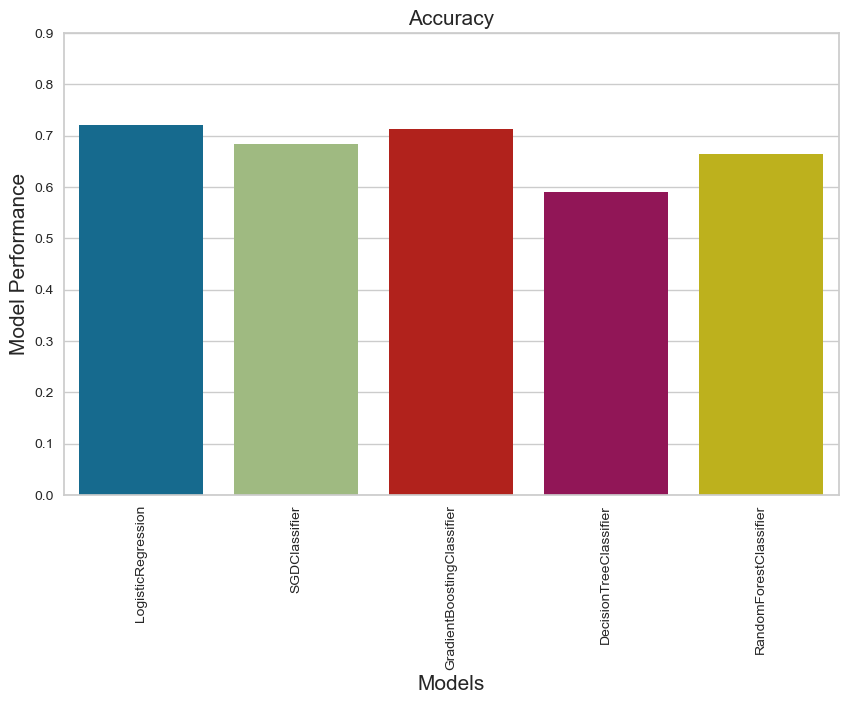

In [93]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.9)
plt.title('Accuracy', fontsize=15)
plt.show()

In [97]:
model_list.pop(-1)
model_list.pop(-1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.02, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1212, splitter='best')

In [98]:
model_list

[LogisticRegression(C=0.846, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=1212, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 SGDClassifier(alpha=0.005, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
               l1_ratio=0.5500000001, learning_rate='invscaling', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
               power_t=0.5, random_state=1212, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.2, loss='deviance', max_depth=4,
                            max_features='log2', max_leaf_node

In [99]:
blended = blend_models(estimator_list = model_list, fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7368,0.0000,0.6838,0.7511,0.7343,0.6758,0.6781
1,0.7393,0.0000,0.6970,0.7500,0.7369,0.6781,0.6807
2,0.7327,0.0000,0.6864,0.7435,0.7310,0.6719,0.6736
3,0.7393,0.0000,0.6620,0.7528,0.7309,0.6763,0.6809
4,0.7228,0.0000,0.6943,0.7233,0.7204,0.6618,0.6623
Mean,0.7342,0.0000,0.6847,0.7441,0.7307,0.6728,0.6751
Std,0.0062,0.0000,0.0123,0.0109,0.0056,0.0059,0.0069


INFO:logs:create_model_container: 29
INFO:logs:master_model_container: 29
INFO:logs:display_container: 20
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.846,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SGDClassifier(alpha=0.005, average=False,
       

In [100]:
pred_holdout = predict_model(blended)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.846,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SGDClassifier(alpha=0.005, average=False,
                                            class_

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7308,0,0.6809,0.7317,0.7268,0.6668,0.6679


In [101]:
# 수업에서 배운 모델을 사용해서 결과를 보였을 때의 결과 
print("ensenble_acc = {}".format(np.mean(np.round(pred_holdout["Label"])==pred_holdout["subject"])))

ensenble_acc = 0.7307692307692307


In [102]:
#제일 좋았던 모델들로 다시 blend
best_blended = blend_models(estimator_list = best_model, fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7632,0.9563,0.7088,0.7731,0.7598,0.7065,0.7097
1,0.7657,0.9527,0.7286,0.7829,0.7655,0.7104,0.7137
2,0.7657,0.9582,0.7188,0.7698,0.7628,0.7112,0.7128
3,0.7393,0.9476,0.6675,0.7530,0.7306,0.6762,0.6808
4,0.7360,0.9419,0.6953,0.7480,0.7357,0.6734,0.6761
Mean,0.7540,0.9513,0.7038,0.7653,0.7509,0.6955,0.6986
Std,0.0134,0.0059,0.0212,0.0129,0.0147,0.0171,0.0166


INFO:logs:create_model_container: 30
INFO:logs:master_model_container: 30
INFO:logs:display_container: 22
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000217EB716B50>),
                             ('e...

In [103]:
best_pred_holdout = predict_model(best_blended)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000217EB716B50>),
                             ('e...
                                          

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7492,0.9461,0.6906,0.7549,0.7450,0.6875,0.6901


In [109]:
# all train set train
final_model = finalize_model(blended)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.846,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SGDClassifier(alpha=0.005, average=False,
                                            clas

In [110]:
# model save 
save_model(final_model, './model/automl_save')


INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.846,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SGDClassifier(alpha=0.005, average=False,
                                            class_weight=Non

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='subject',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                                                           min_impurity_decrease=0.01,
                                                                           min_impurity_split=None,
                                                                       

In [ ]:
# model load 
final_model = load_model('./model/automl_save')

In [111]:
predictions = predict_model(final_model, data = test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.846,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SGDClassifier(alpha=0.005, average=False,
                                            class_

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7435,0,0.7013,0.7466,0.7396,0.6826,0.6848


In [253]:
ensemble_acc = np.mean(np.round(predictions["Label"])==predictions["subject"])

In [113]:
#output이 float이므로 정수형으로 형변환 
automl_predict = np.clip(np.round(predictions["Label"]),0,7)
automl_label = np.array(predictions["subject"])

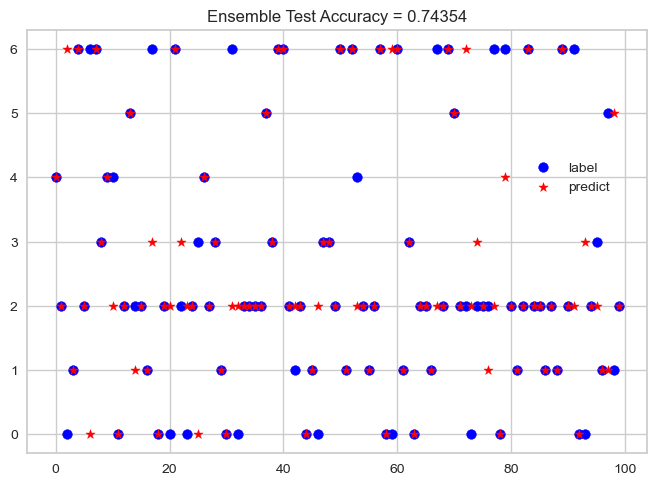

In [306]:
plt.scatter(np.arange(100),automl_label[:100],color = 'blue',label = "label")
plt.scatter(np.arange(100),automl_predict[:100],color = "red",marker='*',label = "predict")
plt.legend(loc=(0.8,0.6))
plt.title("Ensemble Test Accuracy = {:.5f}".format(ensemble_acc))
plt.savefig("./jpeg/Ensemble_accuracy.jpeg")
plt.show()

In [115]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay

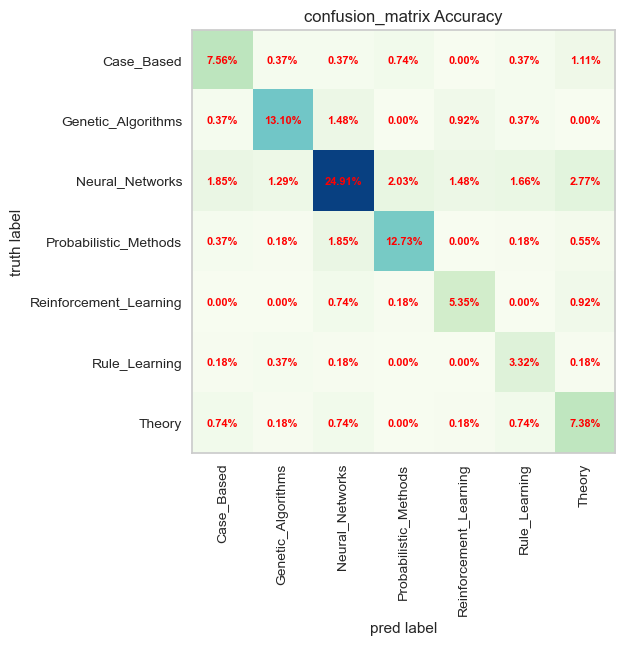

In [116]:
# cm = confusion_matrix(automl_predict,automl_label)

# cm = cm/np.sum(cm)
plt.imshow(cm, cmap='GnBu')         

for (i,j),z in np.ndenumerate(cm):
    plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='red', fontsize=8, fontweight='bold')
    plt.title('confusion_matrix Accuracy')
    plt.xticks(np.arange(0, 7),label_list, rotation = 90)
    plt.yticks(np.arange(0, 7),label_list )
    plt.xlabel("pred label")
    plt.ylabel("truth label")

plt.grid(False)    
plt.savefig('./jpeg/confusion_matrix.jpeg',dpi=200)
plt.show()

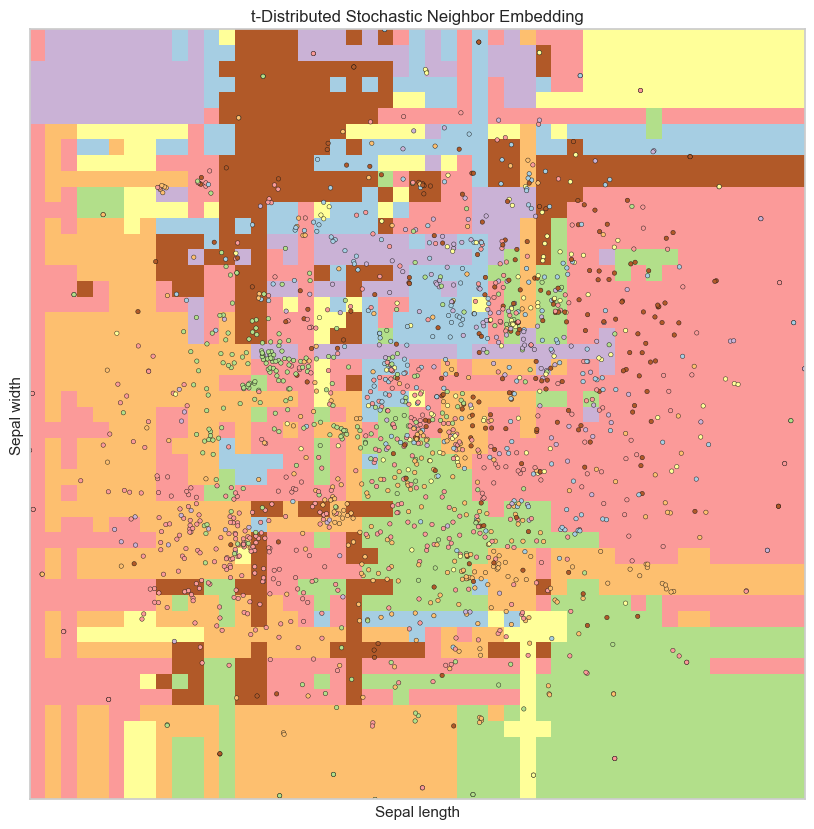

In [136]:
componet_dicision_boundary(final_model,train_x,train_y)

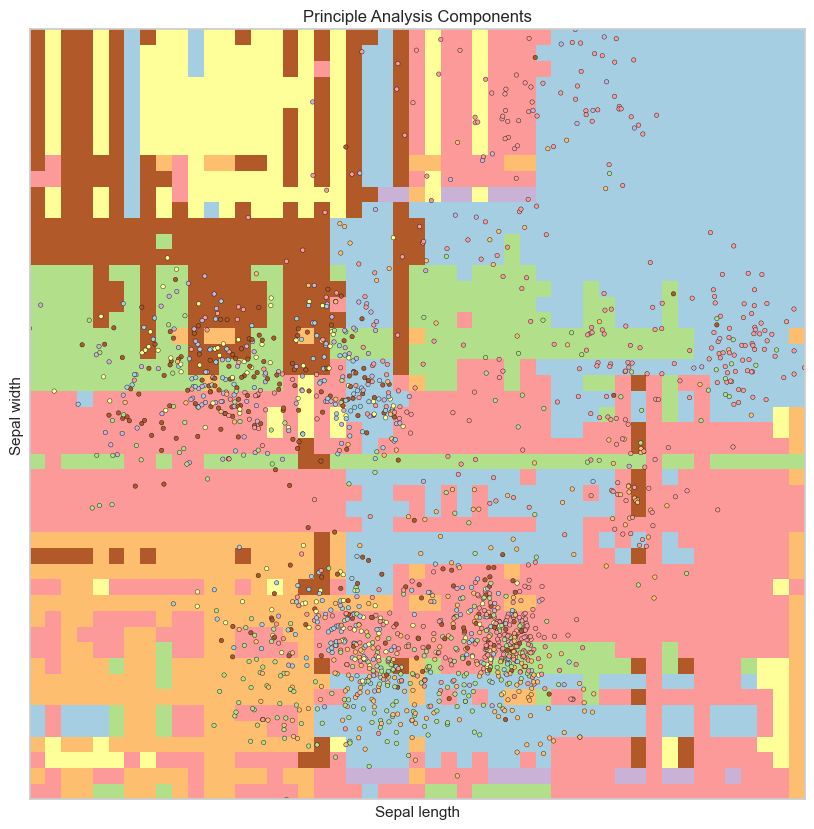

In [137]:
componet_dicision_boundary(final_model,train_x,train_y,mode='pca')

In [117]:
evaluate_model(final_model)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.846,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1212,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SGDClassifier(alpha=0.005, average=False,
                                            clas

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [198]:
class customDataset(Dataset):
    def __init__(self,data,label=None,transform= None):
        super().__init__()
        self.data = torch.tensor(data,dtype =torch.float32)
        self.label = torch.tensor(label,dtype =torch.float32)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        
        if self.label is not None:
            return self.data[index],self.label[index]
        else:
            return self.data[index]

In [229]:
class customDataset(Dataset):
    def __init__(self,data,label=None,transform= None):
        super().__init__()
        self.data = torch.tensor(data,dtype =torch.float32)
        self.label = torch.tensor(label,dtype =torch.float32)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        
        if self.label is not None:
            return self.data[index],self.label[index]
        else:
            return self.data[index]
def linblock(in_dim,out_dim):
    return nn.Sequential(nn.Linear(in_dim,out_dim,bias=False),
                        nn.BatchNorm1d(out_dim),
                        nn.ReLU())
def train_epoch(model, loader, device, criterion, optimizer,display=True,amp = True):
    model.train()   # 모델 train 모드로 바꾸기
    train_loss = []
    train_acc  = []
    # scaler = GradScaler()
    if display:
        bar = tqdm(loader)
    else:
        bar = loader
        
    for i, (data, target) in enumerate(bar):

        optimizer.zero_grad()  # set zero grad about optimizer 
        data, target = data.to(device), target.to(device)  # use gpu if we can use GPU
        
        # with autocast():
        logits = model(data)              # float32 -> float 16 
        loss = criterion(logits, target.to(torch.int64))  # 
            
        # scaler.scale(loss).backward()                   # 3. backward pass
        loss.backward()
        # scaler.step(optimizer)                  # 4. parameter update with gradient descent
        optimizer.step()                  # 4. parameter update with gradient descent
        # scaler.update()
        
        train_loss.append(loss.detach().cpu().numpy())
        
        output = logits.detach().squeeze() # binary class이기 때문에 0.5보다 크면 anomaly라고 분류
        train_loss.append(loss.detach().cpu().numpy())
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == target.reshape(top_class.shape)
        train_acc.append(torch.mean(equals.type(torch.float)).detach().cpu())
        
        if display:bar.set_description('Train Loss: {:.5f} \tAcc: {:.5f}'.format(np.mean(train_loss),(np.mean(train_acc))))
    train_loss = np.mean(train_loss)  # mean loss of one epoch
    train_acc  = np.mean(train_acc)   # mean acc  of one epohc
    return train_loss ,train_acc     
def val_epoch(model, loader, device, criterion,display = False):

    model.eval()  # not train 
    val_loss = []
    val_acc  = []
    LOGITS = []
    PROBS = []

    TARGETS = []
    if display:bar = tqdm(loader)
    else:bar = loader
    with torch.no_grad(): # validation step is not used gradient 
        for (data, target) in bar:
            
            data, target = data.to(device), target.to(device) # 지정한 device로 데이터 옮기기
            # logits = model(data)                              # 1. forward pass
            # with autocast():
            logits = model(data)              # float32 -> float 16 
            loss = criterion(logits, target.to(torch.int64))  # 
            probs = logits.softmax(dim =1)                         # 다중분류 -> 각 클래스일 확률을 전체 1로 두고 계산하기
            output = logits.detach().squeeze()
            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            # loss = criterion(logits, target) # 2. loss 계산
            ps = F.softmax(logits,dim=1)
            top_p,top_class = ps.topk(1,dim=1)
            equals = top_class==target.reshape(top_class.shape)

            
            val_loss.append(loss.detach().cpu().numpy())
            val_acc.append(torch.mean(equals.type(torch.float)).detach().cpu())
            
            if display:bar.set_description('Valid Loss: {:.5f} \tAcc: {:.5f}'.format(np.mean(val_loss),(np.mean(val_acc))))    
            
    #한번에 계산하는 방법
    LOGITS = torch.cat(LOGITS).numpy()
    # PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()
    # val_acc = (PROBS.argmax(1) == TARGETS).mean()
    val_acc = np.mean(val_acc)
    # accuracy : 정확도
    val_loss = np.mean(val_loss)
    # val_acc = np.mean(val_acc)
    return val_loss, val_acc ,LOGITS,TARGETS


In [308]:
simple_dnn = nn.Sequential(linblock(1433,512),
                           linblock(512,128),
                           linblock(128,7))
simple_dnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_dnn.parameters(),lr=1e-3)


In [309]:
train_dataset = customDataset(train_x,train_y)
valid_dataset = customDataset(valid_x,valid_y)
batch_size = 512
train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
valid_loader = DataLoader(valid_dataset,batch_size = batch_size,shuffle = True)
test_dataset  = customDataset(test_x,test_y)
test_loader = DataLoader(test_dataset,batch_size = batch_size,shuffle = True)
device = 'cuda'


In [310]:
tloss = []
vloss = []
tacc = []
vacc = []
for i in tqdm(range(20)):
    train_loss,train_acc = train_epoch(simple_dnn.to(device), train_loader, device, criterion, optimizer,display=True,amp = False)
    valid_loss ,valid_acc,_,_ = val_epoch(simple_dnn,valid_loader, device, criterion,display = True)
    tloss.append(train_loss)
    vloss.append(valid_loss)
    tacc.append(train_acc)
    vacc.append(valid_acc)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

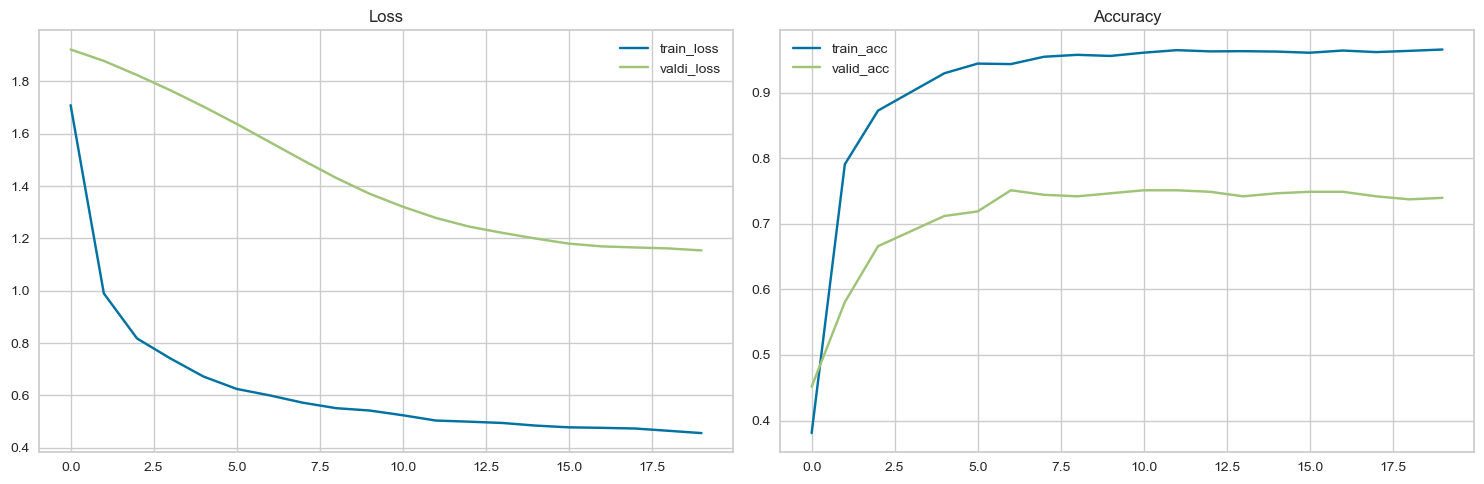

In [311]:
title  = ["Loss","Accuracy"]
f,ax = plt.subplots(1,2,figsize =(15,5))
ax[0].plot(tloss,label = 'train_loss')
ax[0].plot(vloss,label = 'valdi_loss')
ax[0].set_title(title[0])
# ax[0].set_xlabel('Best valid loss  {:.6f}\n epoch  {}'.format(np.min(result[1]),np.argmin(result[1])))
ax[0].legend()

ax[1].plot(tacc ,label = 'train_acc')
ax[1].plot(vacc, label = "valid_acc")
ax[1].set_title(title[1])
# ax[1].set_xlabel('Best_train_acc  {:.2f}\nBest_valid_acc  {:.2f}'.format(np.max(result[2]),np.max(result[3])))
ax[1].legend()

f.tight_layout()
plt.savefig(f"./jpeg/dnn_loss.jpeg",dpi=200,facecolor = "w")
plt.show()

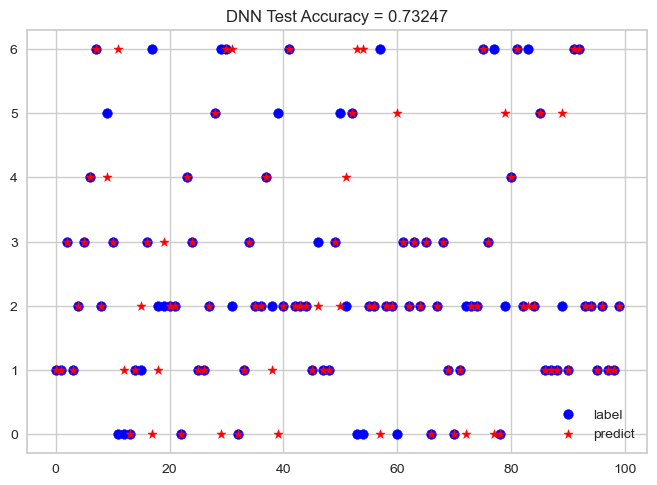

In [312]:
test_dataset  = customDataset(test_x,test_y)
test_loader = DataLoader(test_dataset,batch_size = len(test_x),shuffle = True)
data,label = next(iter(test_loader))
model_predict = simple_dnn(data.to(device))
proba = F.softmax(model_predict,dim=1)
proba = torch.argmax(proba,1)
dnn_acc = torch.mean((proba.detach().cpu()==label).float())
plt.scatter(np.arange(100),label[:100],color = 'blue',label = "label")
plt.scatter(np.arange(100),proba.detach().cpu()[:100],color = "red",marker='*',label = "predict")
plt.legend()
plt.title("DNN Test Accuracy = {:.5f}".format(dnn_acc))
plt.savefig("./jpeg/DNN_accuracy.jpeg",dpi=200)
plt.show()

In [251]:
train_x.shape

(1732, 1433)

In [313]:
# model_list = [tune_lr,tune_svm,tune_gbc,tune_dt,tune_rf]
# predict = []
# for i in model_list:
#     predict.append(predict_model(i))
#     # i.fit(train_x,train_y)
    
acc = []
model_name = []
for idx,i in enumerate(predict):
    acc.append(np.mean(np.round(i["Label"])==i["subject"]))
    model_name.append(type(model_list[idx]).__name__)
    print(f"{model_name[-1]}: acc  {acc[-1]}")

model_name.append("ensemble_model")
model_name.append("DNN")

acc.append(ensemble_acc)
acc.append(dnn_acc.numpy())

LogisticRegression: acc  0.72
SGDClassifier: acc  0.683076923076923
GradientBoostingClassifier: acc  0.7123076923076923
DecisionTreeClassifier: acc  0.5907692307692308
RandomForestClassifier: acc  0.6646153846153846


In [314]:
model_name.append("GCN")

acc.append(0.7731)
result_df = pd.DataFrame({'Model': model_name, 'Score': np.array(acc)}).reset_index(drop=True)
result_df

,Model,Score
0,LogisticRegression,0.720000
1,SGDClassifier,0.683077
2,GradientBoostingClassifier,0.712308
3,DecisionTreeClassifier,0.590769
4,RandomForestClassifier,0.664615
5,ensemble_model,0.743542
6,DNN,0.732472
7,GCN,0.773100


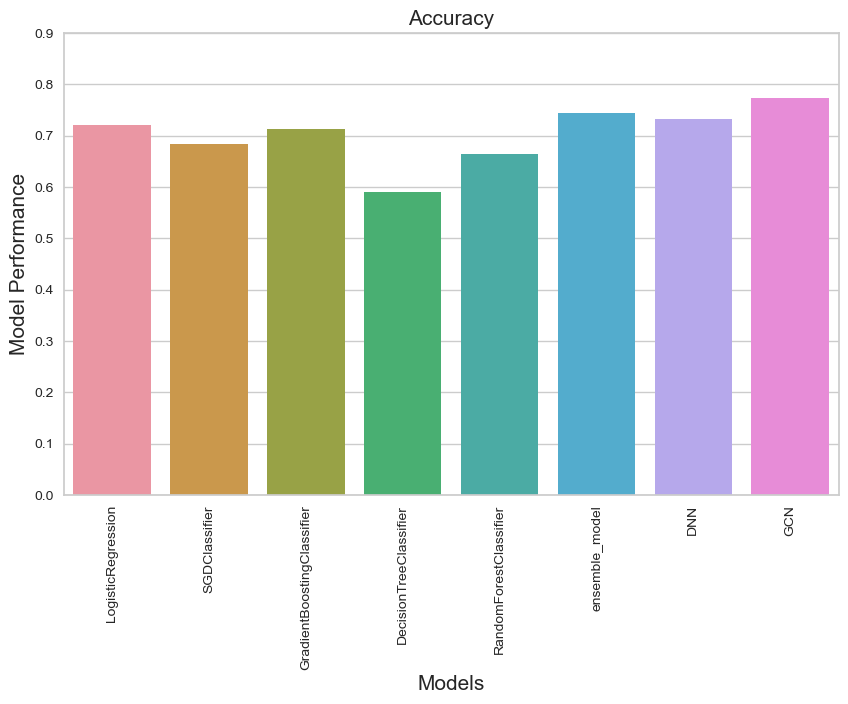

In [315]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'],)
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.9)
plt.title('Accuracy', fontsize=15)
plt.savefig("./jpeg/total_accuracy.jpeg",dpi=200)
plt.show()